In [1]:
!pip install gensim
!pip install wordcloud
!pip install nltk

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
     ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.0 MB 1.9 MB/s eta 0:00:13
     ---------------------------------------- 0.2/24.0 MB 2.2 MB/s eta 0:00:11
      --------------------------------------- 0.3/24.0 MB 2.5 MB/s eta 0:00:10
      --------------------------------------- 0.4/24.0 MB 2.4 MB/s eta 0:00:10
      --------------------------------------- 0.5/24.0 MB 2.3 MB/s eta 0:00:11
      --------------------------------------- 0.5/24.0 MB 2.3 MB/s eta 0:00:11
     - -------------------------------------- 0.6/24.0 MB 2.1 MB/s eta 0:00:11
     - -------------------------------------- 0.8/24.0 MB 2.1 MB/s eta 0:00:12
     - -------------------------------------- 0.9/24.0 MB 2.2 MB/s eta 0:00:11
     - -------------------------------------- 1.0/24.0 MB 2.2 MB/s eta 0:00:11
     - -------------------------------------- 1.1/24.0 MB 2.2 MB/s eta 0:00:11


1. Gensim: It is a library for unsupervised topic modeling and document indexing. It provides efficient algorithms for modeling latent topics in large-scale text collections, such as those generated by search engines or online platforms.
2. NLTK: The Natural Language Toolkit (NLTK) is a library for working with human language data. It provides tools for tokenizing, stemming, and lemmatizing text and for performing part-of-speech tagging, named entity recognition, and sentiment analysis.
3. Matplotlib：它是一个 Python 绘图库。它用于可视化主题模型的结果，例如主题在文档中的分布或单词和主题之间的关系。
4. Scikit-learn：它是一个Python机器学习库。它提供了多种用于建模主题的算法，包括潜在狄利克雷分配 (LDA)、非负矩阵分解 (NMF) 等。
5. Pandas：这是一个Python数据分析库。它提供了用于以方便高效的方式处理结构化数据（例如主题模型的结果）的数据结构和函数。

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

### 第2步：导入并读取数据集

In [5]:
#loading the file from its local path into a dataframe
df=pd.read_csv(r"data/abcnews-date-text.csv")

df

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


### 第三步：数据预处理
下面的代码选择数据集中的前 1,000,000 行，并删除除“标题文本”列之外的其余列，然后将新数据框命名为“data”。


In [7]:
data = df.sample(n=100000, axis=0) #to select only a million rows to use in our dataset

data= data['headline_text']  #to extract the headline_text column and give it the variable name data

接下来，我们进行词形还原并从数据中删除停用词。

词形还原将单词简化为基本词根，从而降低了文本数据的维度和复杂性。我们将 WordNetLemmatizer() 分配给该变量。这对于提高算法的性能很重要，并有助于算法关注单词的含义而不是表面形式。

停用词是常见的单词，例如“the”和“a”，经常出现在文本数据中，但没有太多含义。删除它们有助于降低数据的复杂性，加快算法速度，并更容易找到有意义的模式。

下面的代码下载用于执行词形还原和删除停用词的依赖项，然后定义一个函数来处理数据，最后将该函数应用于我们的数据框“数据”。

In [8]:
# lemmatization and removing stopwords

#downloading dependencies
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

#function to lemmatize and remove stopwords from the text data
def preprocess(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words


#applying the function to the dataset
data = data.apply(preprocess)
data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


723537         [china, next, president, vanishes, limelight]
1007542           [elli, taking, lecture, christopher, pyne]
992696                                  [sjostrand, inquest]
658046     [australia, 's, russian, migrant, see, electio...
60645      [united, set, double, van, nistelrooys, pay, c...
                                 ...                        
565510         [sa, denies, overreacting, yuendumu, arrival]
954033          [sb, advertising, revenue, raised, :, husic]
994314                   [shearer, optimism, ian, ross, qld]
1227957    [coronavirus, warning, auburn, berala, sydney,...
965721                              [strike, zone, july, 17]
Name: headline_text, Length: 100000, dtype: object

### 第 4 步：训练模型
主题数量设置为 5（可以设置为想要从数据中提取的主题数量），传递次数为 20，alpha 和 eta 设置为“auto”。这让模型可以估计适当的值。您可以尝试不同的参数以查看对结果的影响。

下面的代码处理数据以删除出现在少于 5 个文档中的单词以及出现在超过 50% 的数据中的单词。这可确保模型不包含数据中出现较少或出现较多的单词。例如，一个国家的新闻头条会大量提及该国家，这将改变我们模型的有效性。然后我们根据过滤后的数据创建一个语料库。然后，我们选择主题数量并训练 Lda 模型，使用“显示主题”从模型中获取主题，然后打印主题

In [10]:
# Create a dictionary from the preprocessed data
dictionary = Dictionary(data)

# Filter out words that appear in fewer than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

bow_corpus = [dictionary.doc2bow(text) for text in data]

# Train the LDA model
num_topics = 5
ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['plan', 'council', 'interview', 'back', 'win', 'report', 'change', 'election', 'take', 'help']
Topic: 1
Words: ['say', 'call', 'nsw', 'govt', 'qld', 'health', 'wa', 'water', 'sa', 'coast']
Topic: 2
Words: ['u', 'australian', 'market', 'home', 'world', 'claim', 'china', 'price', 'fear', 'cup']
Topic: 3
Words: ['new', 'australia', 'fire', 'year', 'hit', 'get', 'open', 'may', 'set', 'case']
Topic: 4
Words: ['police', 'man', 'court', 'death', 'woman', 'sydney', 'crash', 'day', 'child', 'attack']


### 第 5 步：绘制主题的词云
词云是一种数据可视化工具，用于可视化大量文本数据中最常出现的单词，有助于理解数据中存在的主题。它在文本数据分析中很重要，它提供了对数据结构和内容的宝贵见解。

词云是一种简单但有效的可视化大量文本数据内容的方法。它以图形格式显示最常用的单词，使用户可以轻松识别数据中存在的关键主题和主题。词云中每个词的大小代表其出现的频率，因此词云中最大的词对应于数据中最常出现的词。

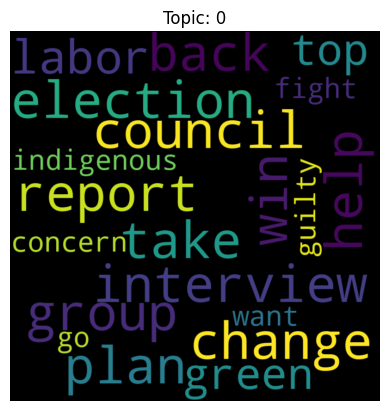

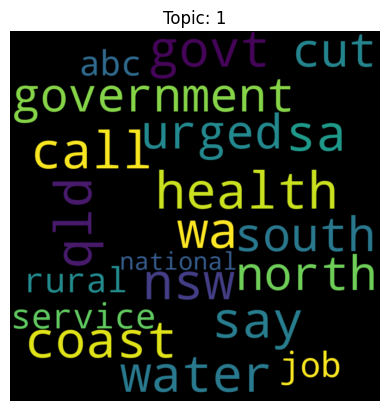

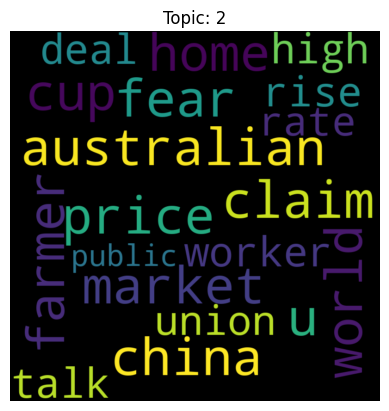

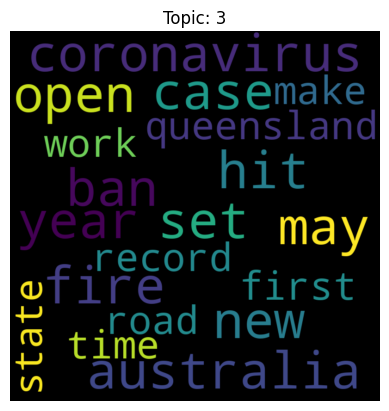

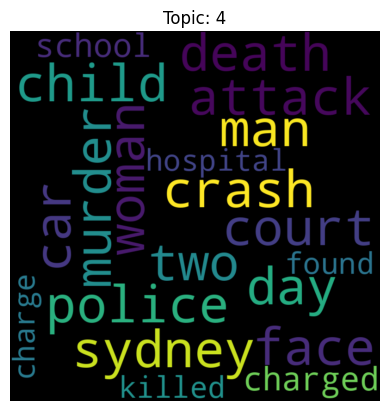

In [12]:
# Plotting a wordcloud of the topics 

for topic_id, topic in enumerate(ldamodel.print_topics(num_topics=num_topics, num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(topic_words)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic: {}".format(topic_id))
    plt.show()